In [ ]:
# %% [Imports and Data Loading]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import shap
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [5]:
# %%
# Load and clean data
df = pd.read_csv('Dataset.csv')

# Data cleaning
string_cols = df.columns[df.dtypes == 'object']
df[string_cols] = df[string_cols].apply(lambda col: np.char.replace(col.values.astype(str), "'", ""))
df['category'] = df['category'].str.replace('es_', '', regex=False)

# Handle age column properly
print(f"\nOriginal value counts in age:\n{df['age'].value_counts(dropna=False)}")
df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Convert to numeric, coerce failures to NaN
df['age'] = df['age'].where(df['age'].notna(), -1)  # Replace NaN with -1 (special value)
df['age'] = df['age'].astype('Int64')  # Now safely convert to Int64

# Convert other columns
cols = ['zipcodeOri', 'zipMerchant']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').astype('Int64')
df['gender'] = df['gender'].replace('E', 'Unknown')

# Create time-based features
df['datetime'] = pd.to_datetime(df['step'], unit='h')
df['hour'] = df['datetime'].dt.hour
df['is_weekend'] = df['datetime'].dt.dayofweek >= 5

# Behavioral features with NaN handling
df['amount_to_avg'] = df['amount'] / df.groupby('customer')['amount'].transform('mean').replace(0, 1)
df['merchant_fraud_rate'] = df.groupby('merchant')['fraud'].transform('mean').fillna(0)
df['customer_risk_score'] = df.groupby('customer')['fraud'].transform('mean').fillna(0)

# Create age groups (handling our -1 value)
df['age_group'] = pd.cut(
    df['age'],
    bins=[-2, -1, 25, 35, 45, 55, 65, 100],  # -2 to -1 catches our -1 value
    labels=['Unknown', '<25', '25-35', '35-45', '45-55', '55-65', '65+']
)

# Explicitly define categorical and numeric features
categorical_features = [
    'age_group', 
    'gender', 
    'category', 
    'customer', 
    'merchant'
    # Add other categorical columns as needed
]

numeric_features = [
    'amount',
    'amount_to_avg',
    'merchant_fraud_rate', 
    'customer_risk_score',
    'zipcodeOri',
    'zipMerchant'
    # Add other numeric columns as needed
]



Original value counts in age:
age
2    168425
3    132505
4     98068
5     56465
1     52384
6     24071
0      2203
U      1057
Name: count, dtype: int64


In [7]:
# %% [Train-Test Split]
X = df.drop(columns=['fraud', 'datetime', 'step'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
for col in categorical_features:
    df[col] = df[col].astype('category')

 # %% [Preprocessing Pipeline]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop')

In [9]:
# Model Training
print("\nTraining optimized fraud detection model...")

lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=len(y_train[y_train==0])/max(1, len(y_train[y_train==1])),
    num_leaves=63,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=500,
    reg_alpha=0.2,
    reg_lambda=0.2,
    random_state=42,
    verbose=-1
)

# %% [Model Pipeline]
model = make_pipeline(
    preprocessor,
    SMOTE(sampling_strategy=0.3, random_state=42),
    lgb.LGBMClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        verbosity=-1
    )
)
model.fit(X_train, y_train)


Training optimized fraud detection model...


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'amount_to_avg',
                                                   'merchant_fraud_rate',
                                                   'customer_risk_score',
                                                   'zipcodeOri',
                                                   'zipMerchant']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['age_group', 'gender',
                                                   'category', 'customer',
                                                   'merchant'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('lgbmclassifier',
                 LGBMClassifier(random_state=42,
                                scale_pos_weight=81.43011166730844,
                                verbosity=-1))])

In [ ]:
# %% [Model Evaluation]
print("\nModel Evaluation:")
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba):.4f}")



Model Evaluation:


c:\Users\Kolluri Sruthi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Kolluri Sruthi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    105738
           1       0.47      0.98      0.64      1298

    accuracy                           0.99    107036
   macro avg       0.74      0.98      0.82    107036
weighted avg       0.99      0.99      0.99    107036

ROC AUC: 0.9987
PR AUC: 0.9144


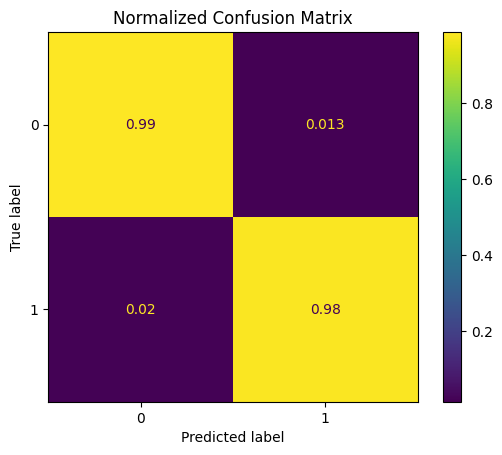


Generating SHAP explanations...


In [12]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.title('Normalized Confusion Matrix')
plt.show()


In [14]:
# Get processed feature names
processed_features = numeric_features.copy()
if 'cat' in preprocessor.named_transformers_:
    cat_encoder = preprocessor.named_transformers_['cat']
    processed_features += list(cat_encoder.get_feature_names_out(categorical_features))



Generating SHAP explanations...


c:\Users\Kolluri Sruthi\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


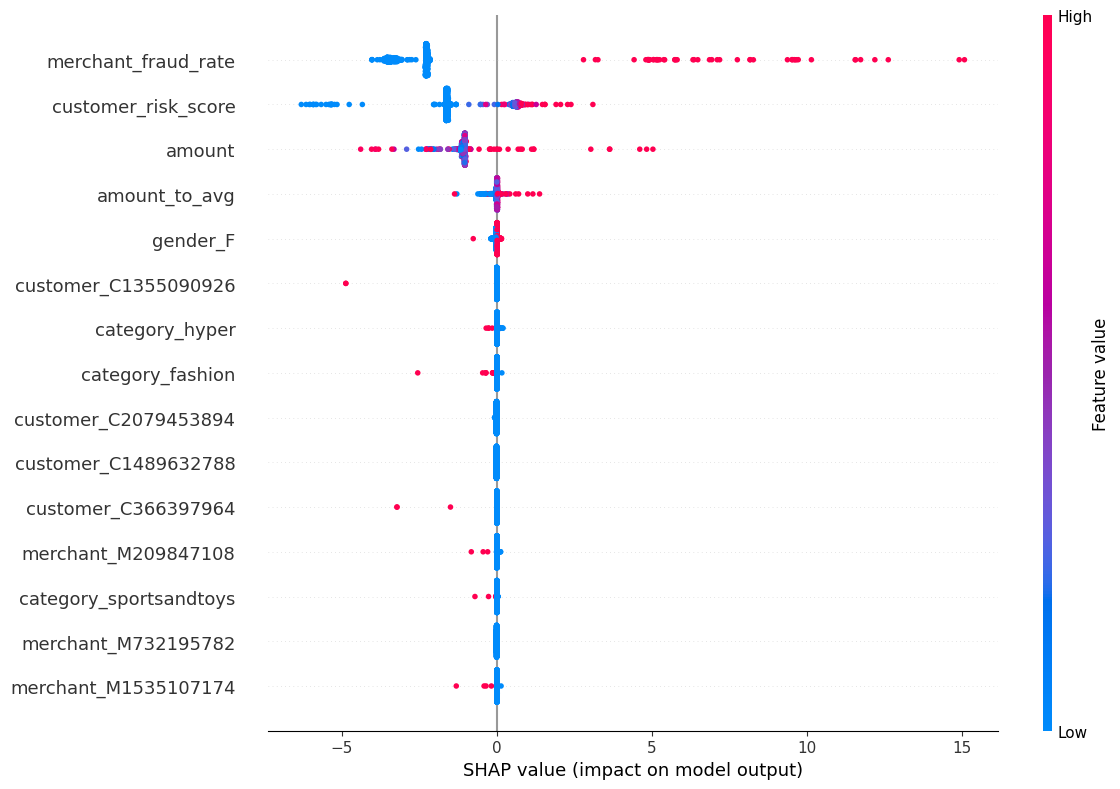

In [17]:
# %% [Corrected SHAP Explainability]
print("\nGenerating SHAP explanations...")

# 1. First ensure we're using the correct model step
model_step = model.named_steps['lgbmclassifier']

# 2. Create a sample for SHAP calculation (memory efficiency)
sample_size = min(1000, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)
X_sample_processed = preprocessor.transform(X_sample)

# 3. Get feature names correctly
processed_features = numeric_features.copy()
if 'cat' in preprocessor.named_transformers_:
    cat_encoder = preprocessor.named_transformers_['cat']
    processed_features += list(cat_encoder.get_feature_names_out(categorical_features))

# 4. Calculate SHAP values properly
explainer = shap.TreeExplainer(model_step)
shap_values = explainer.shap_values(X_sample_processed)

# 5. Handle binary classification case
# For binary classification, shap_values may be a list of two arrays
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Take the SHAP values for class 1 (fraud)

# 6. Convert to dense array if sparse
if hasattr(shap_values, 'toarray'):
    shap_values = shap_values.toarray()

# 7. Create proper feature matrix
shap_values_matrix = np.array(shap_values).reshape(len(X_sample), -1)

# 8. Plot
shap.summary_plot(
    shap_values_matrix, 
    features=X_sample_processed.toarray(),
    feature_names=processed_features,
    max_display=15,
    plot_size=(12, 8)
)

In [ ]:

# Save Model
joblib.dump(model, 'fraud_detection_pipeline_v2.joblib')
print("\nSaved model pipeline to 'fraud_detection_pipeline_v2.joblib'")